In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import warnings
import tensorflow as tf
from skimage.filters import gaussian
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
warnings.filterwarnings('ignore')

In [2]:
# Set visualization parameters
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]

# Define the image_counter function to count the images in each class directory
def image_counter(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len([f for f in os.listdir(class_path) if f.endswith('.jpg') or f.endswith('.png')])
    return class_counts

# Define a function to plot class distribution
def plot_class_distribution(class_dist):
    keys = list(class_dist.keys())
    values = list(class_dist.values())
    explode = (0.1,)*len(keys)
    
    labels = [f'{key} ({value} images)' for key, value in zip(keys, values)]
    
    plt.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=colors, textprops={'fontsize': 12, "fontweight" : "bold", "color":"darkblue"},  wedgeprops=
           {'edgecolor':'darkblue'} , labeldistance=1.15)
    plt.title("Distribution of \nAlzheimer MRI Images", size=12, fontweight="bold")
    plt.show()

# Define a function to visualize samples
def visualize_samples(class_path, num_samples=5):
    image_files = [image for image in os.listdir(class_path) if image.endswith('.jpg')]

    fig, ax = plt.subplots(1, num_samples, facecolor="gray")
    fig.suptitle(f'{os.path.basename(class_path)} Brain MRI Samples', color="yellow", fontsize=16, fontweight='bold', y=0.75)
    
    for i in range(num_samples):
        image_path = os.path.join(class_path, image_files[i])
        img = mpimg.imread(image_path)

        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(f'Sample {i+1}', color="aqua")

    plt.tight_layout()
    plt.show()

# Define a function to visualize a batch of images
def visualize_batch_images(batch, number_of_images=5, class_names=None):
    fig, ax = plt.subplots(ncols=number_of_images, figsize=(20, 20), facecolor="gray")
    fig.suptitle("Brain MRI (Alzheimer) Samples in the Batch", color="yellow", fontsize=18, fontweight='bold', y=0.6)
    for idx, img in enumerate(batch[0][:number_of_images]):
        ax[idx].imshow(img)
        class_no = batch[1][idx]
        ax[idx].set_title(class_names[class_no], color="aqua")
        ax[idx].set_xticklabels([])
        ax[idx].set_yticklabels([])
    plt.show()

# Define a function to check data imbalance
def check_data_imbalance(data, class_names):
    class_counts = {}
    
    for _, labels in data:
        labels = labels.numpy()
        for label in labels:
            if label in class_counts:
                class_counts[label] += 1
            else:
                class_counts[label] = 1

    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes', fontsize=14)
    plt.ylabel('Number of samples', fontsize=14)
    plt.title('Class Distribution', fontsize=16)
    plt.xticks(classes, class_names)
    plt.show()

    return class_counts

# Define a function to compute class weights
def compute_class_weights(data):
    labels = []

    for _, label_batch in data:
        labels.extend(label_batch.numpy())

    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    return dict(zip(np.unique(labels), class_weights))

# Define callbacks for model training
def create_callbacks():
    checkpoint_filepath = '/tmp/checkpoint.keras'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        save_freq='epoch',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    es_callback = EarlyStopping(
        monitor='val_loss',
        patience=20,
        verbose=1
    )
    return [model_checkpoint_callback, es_callback]

# Intensity normalization function
def normalize_intensity(image):
    return tf.image.per_image_standardization(image)

# Spatial smoothing function
def smooth_image(image, sigma=1):
    # Gaussian smoothing
    return tf.image.adjust_brightness(image, delta=0.1) # Adjust brightness as a placeholder



Found 6400 files belonging to 4 classes.


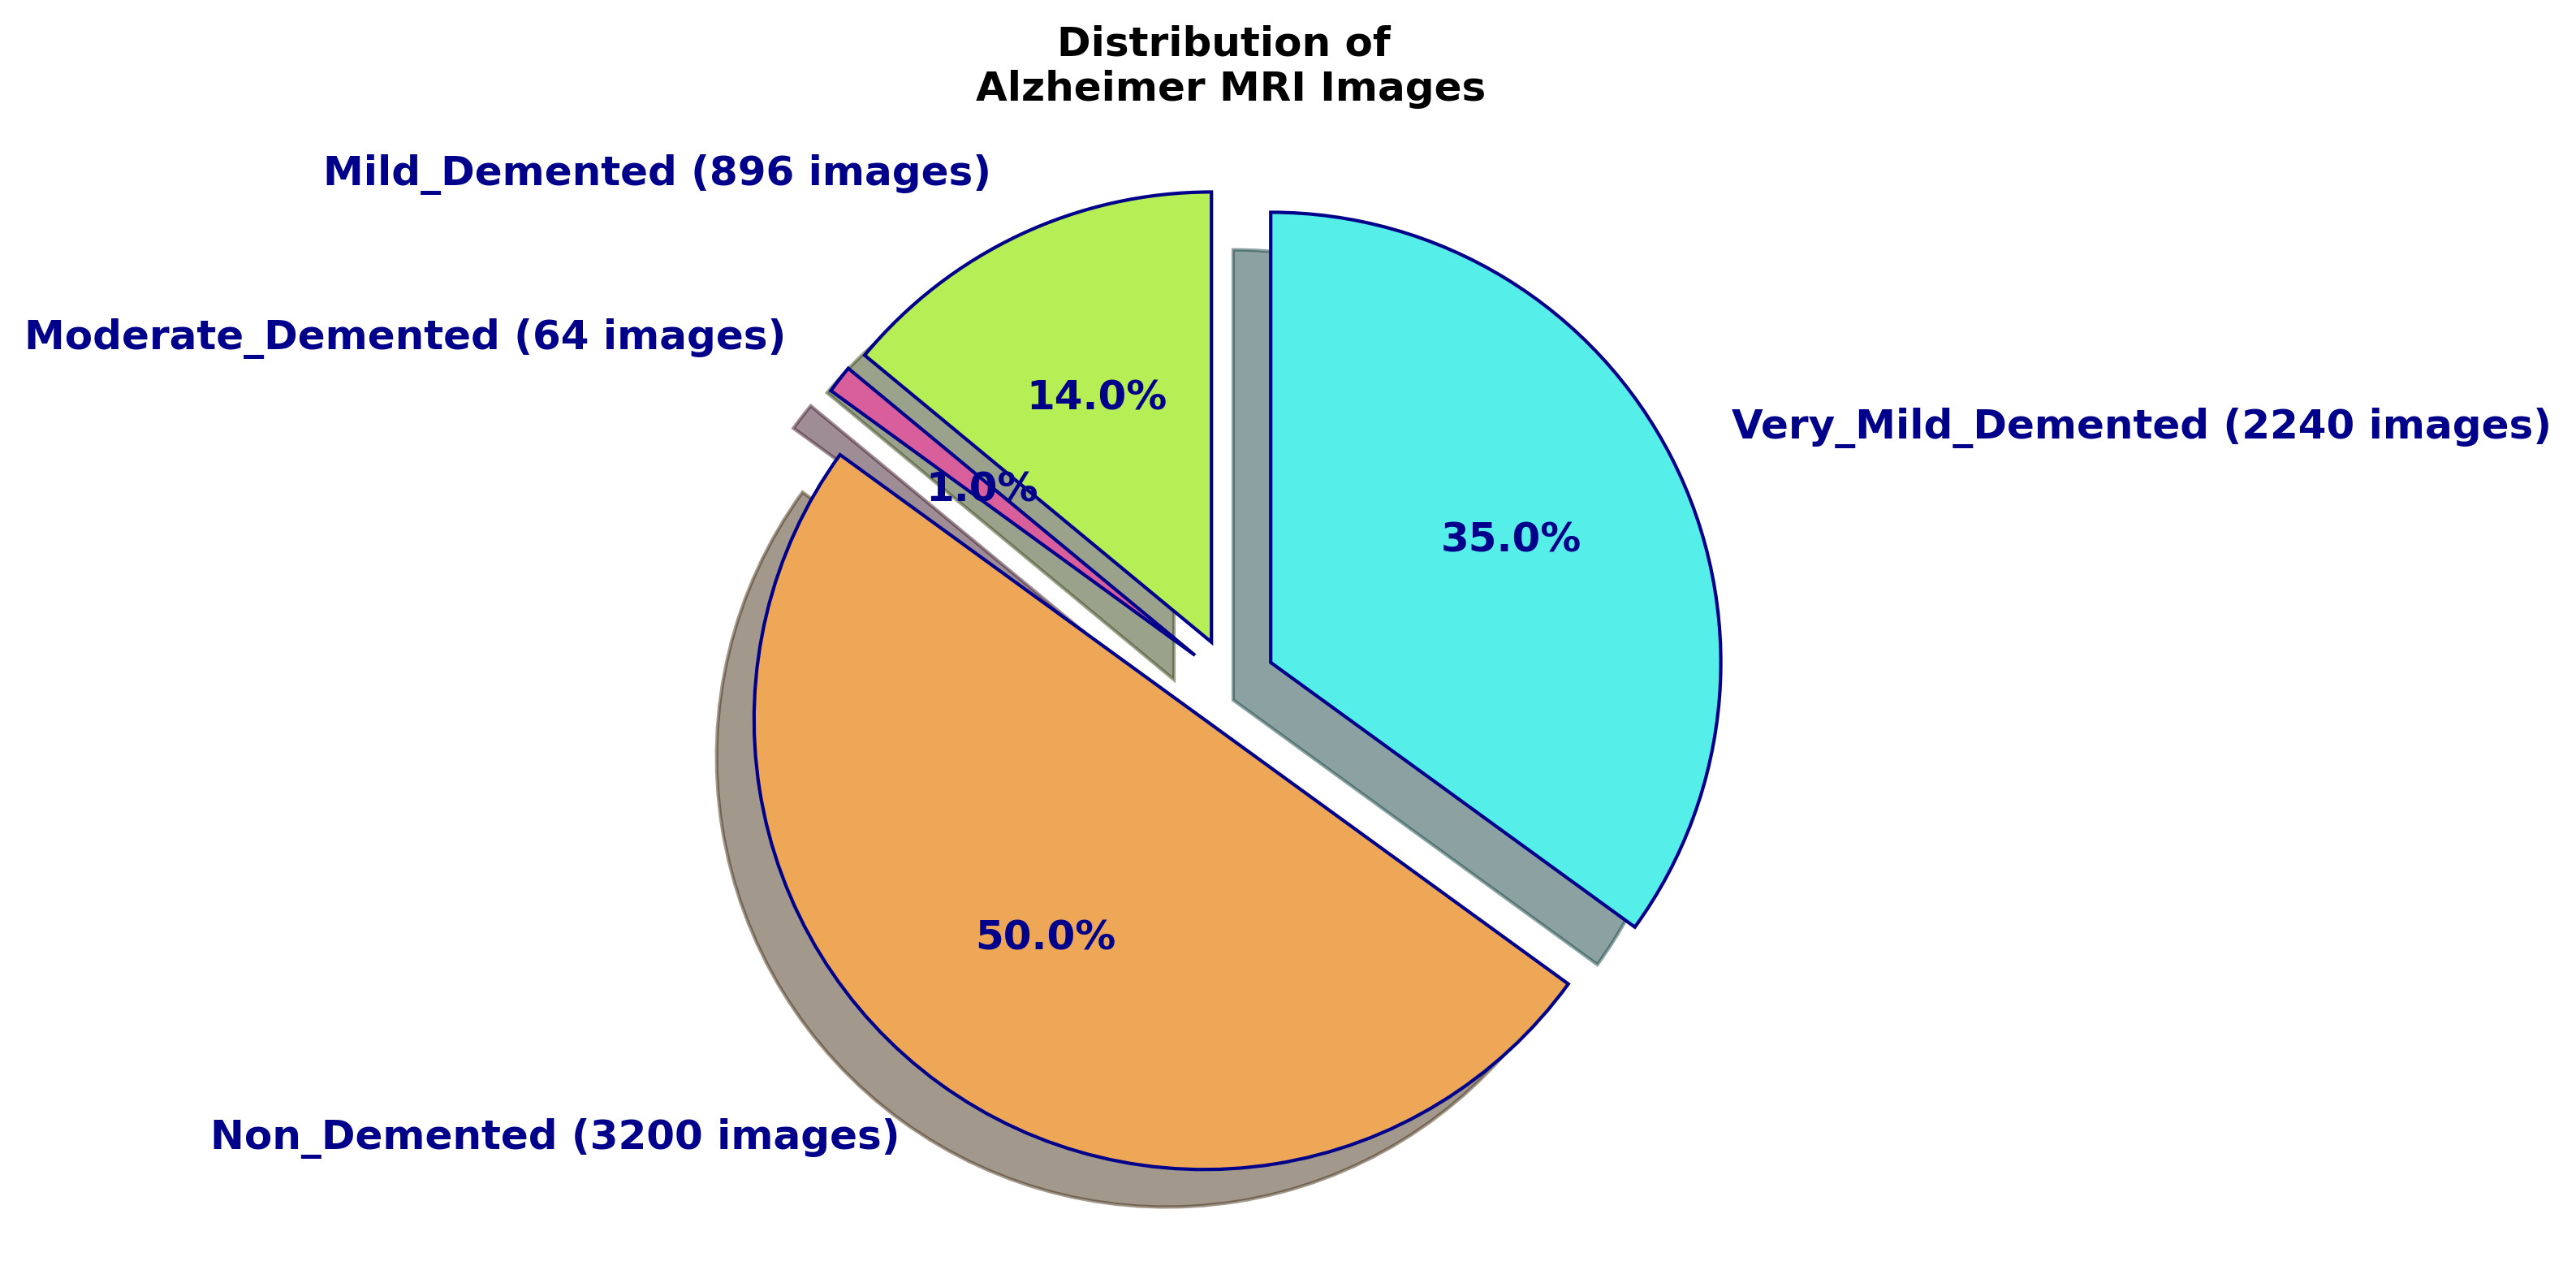

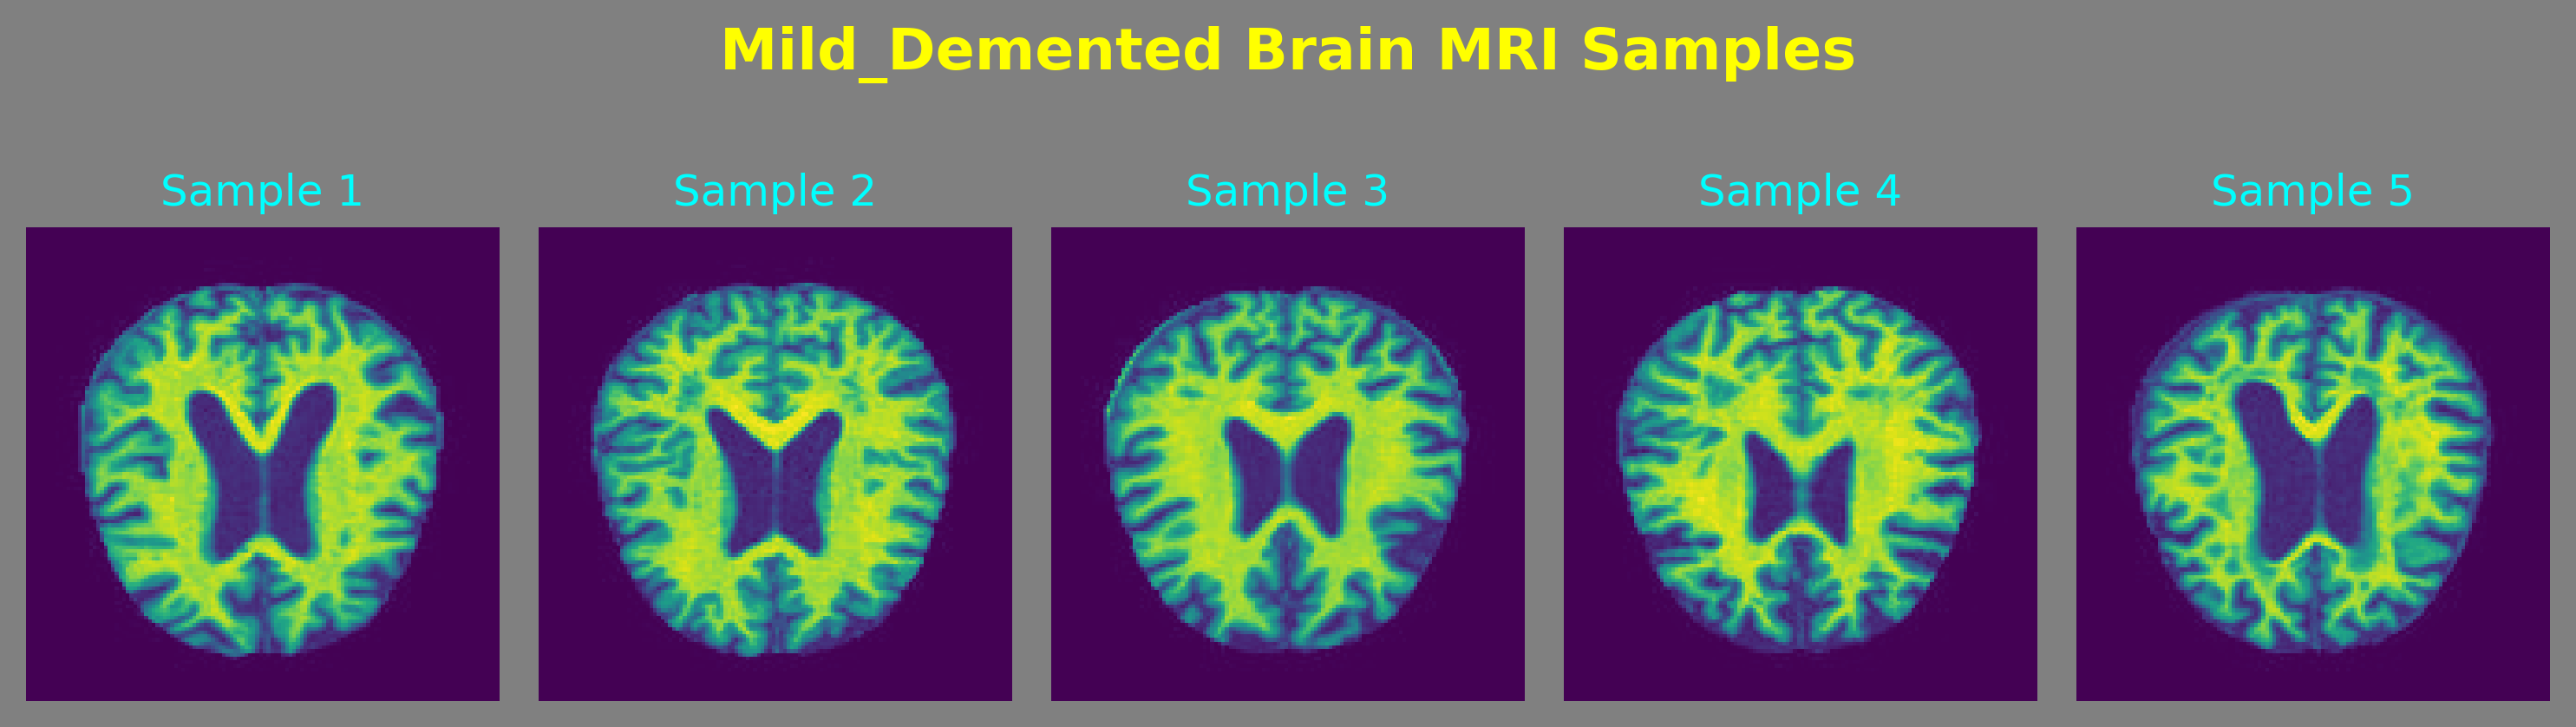

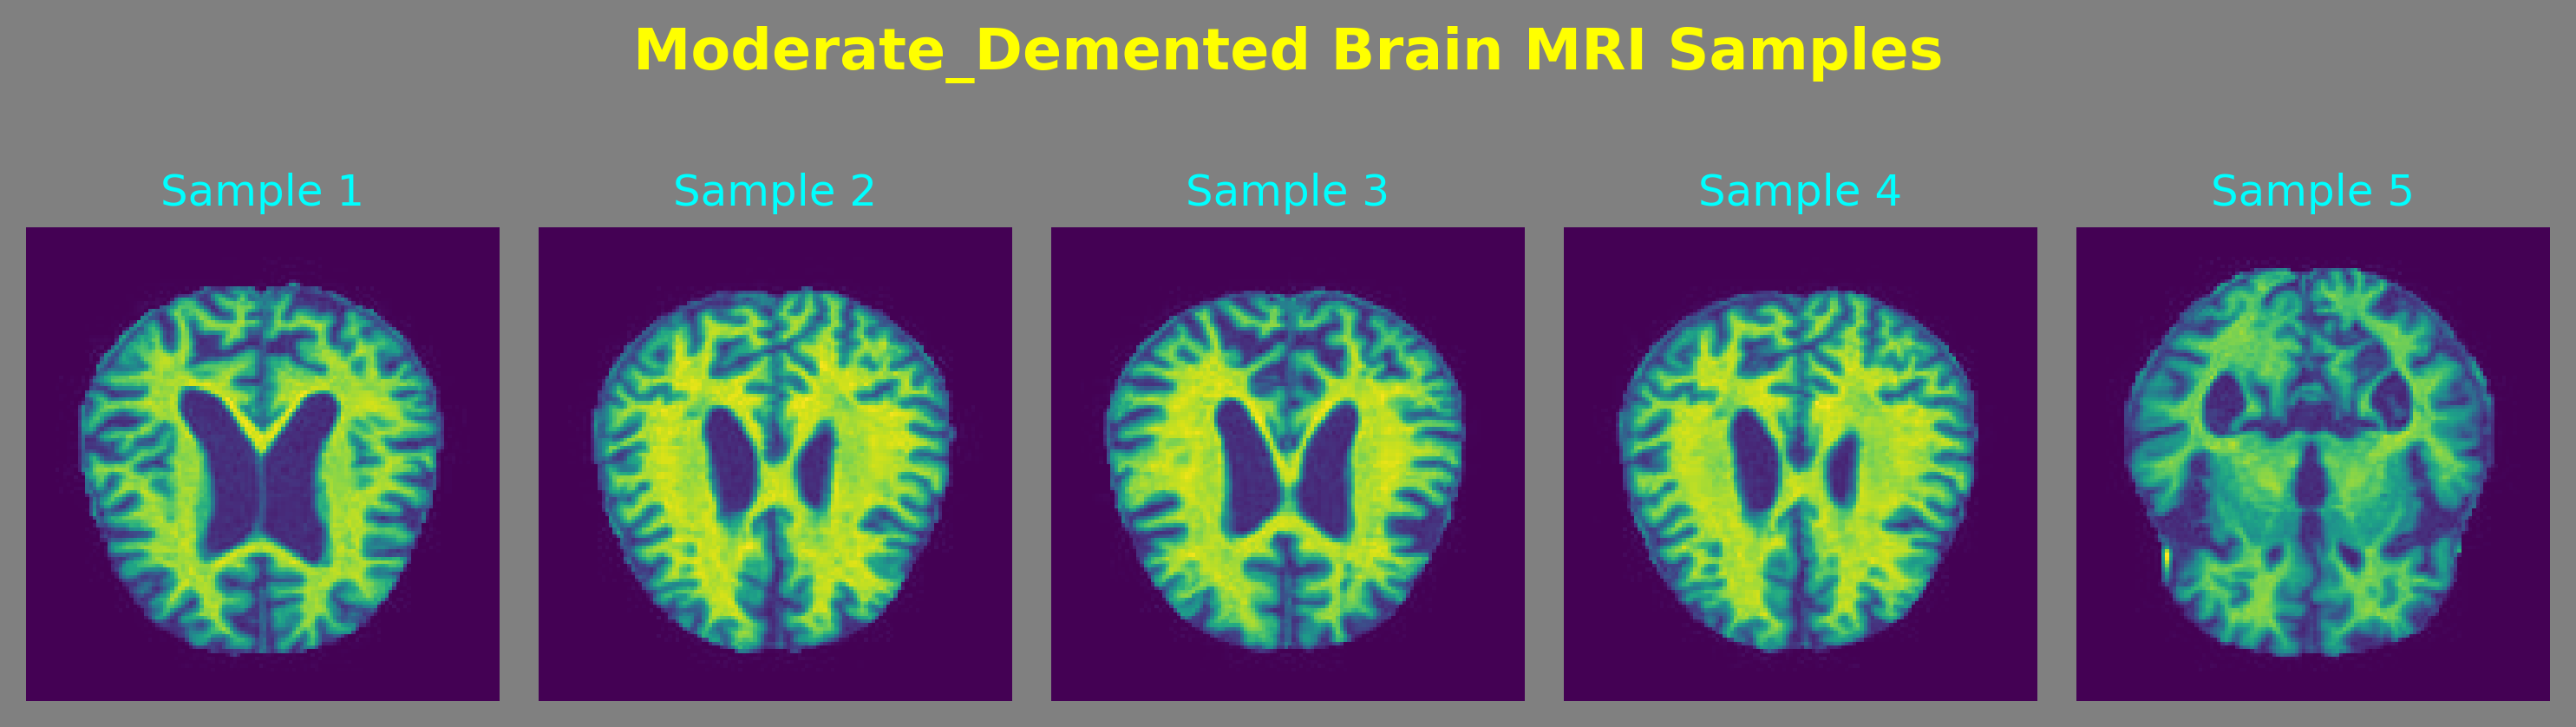

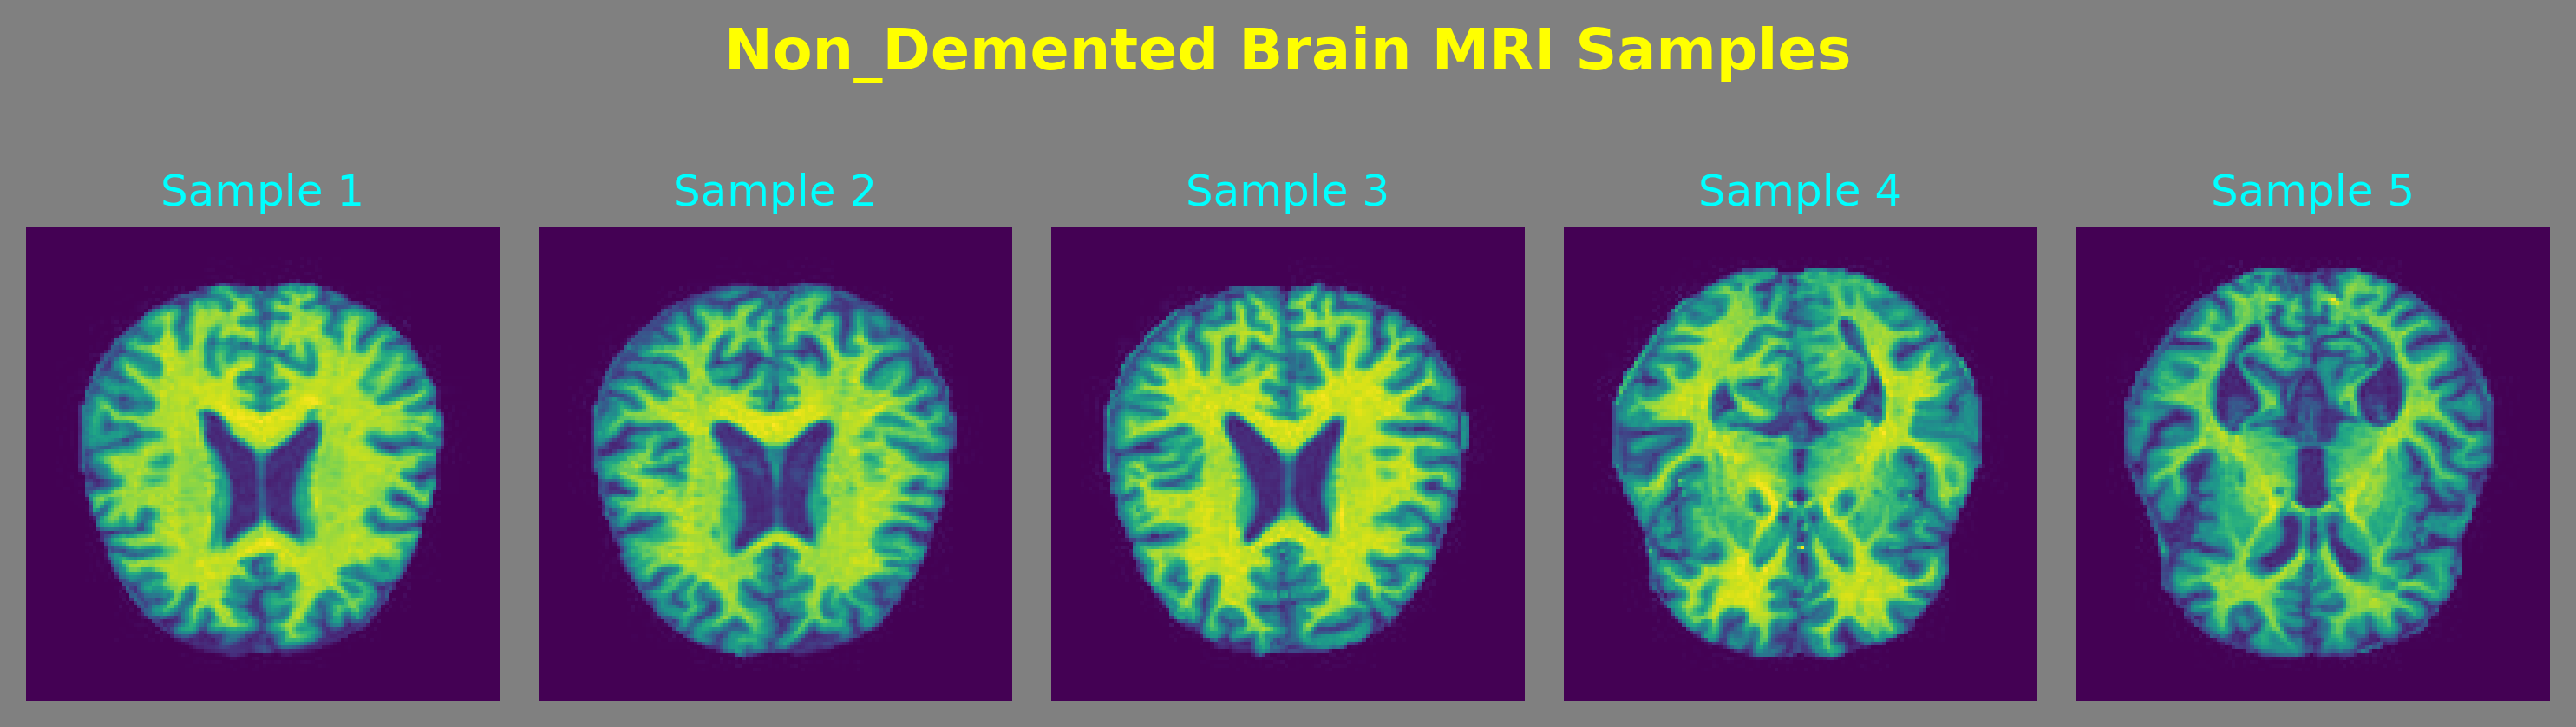

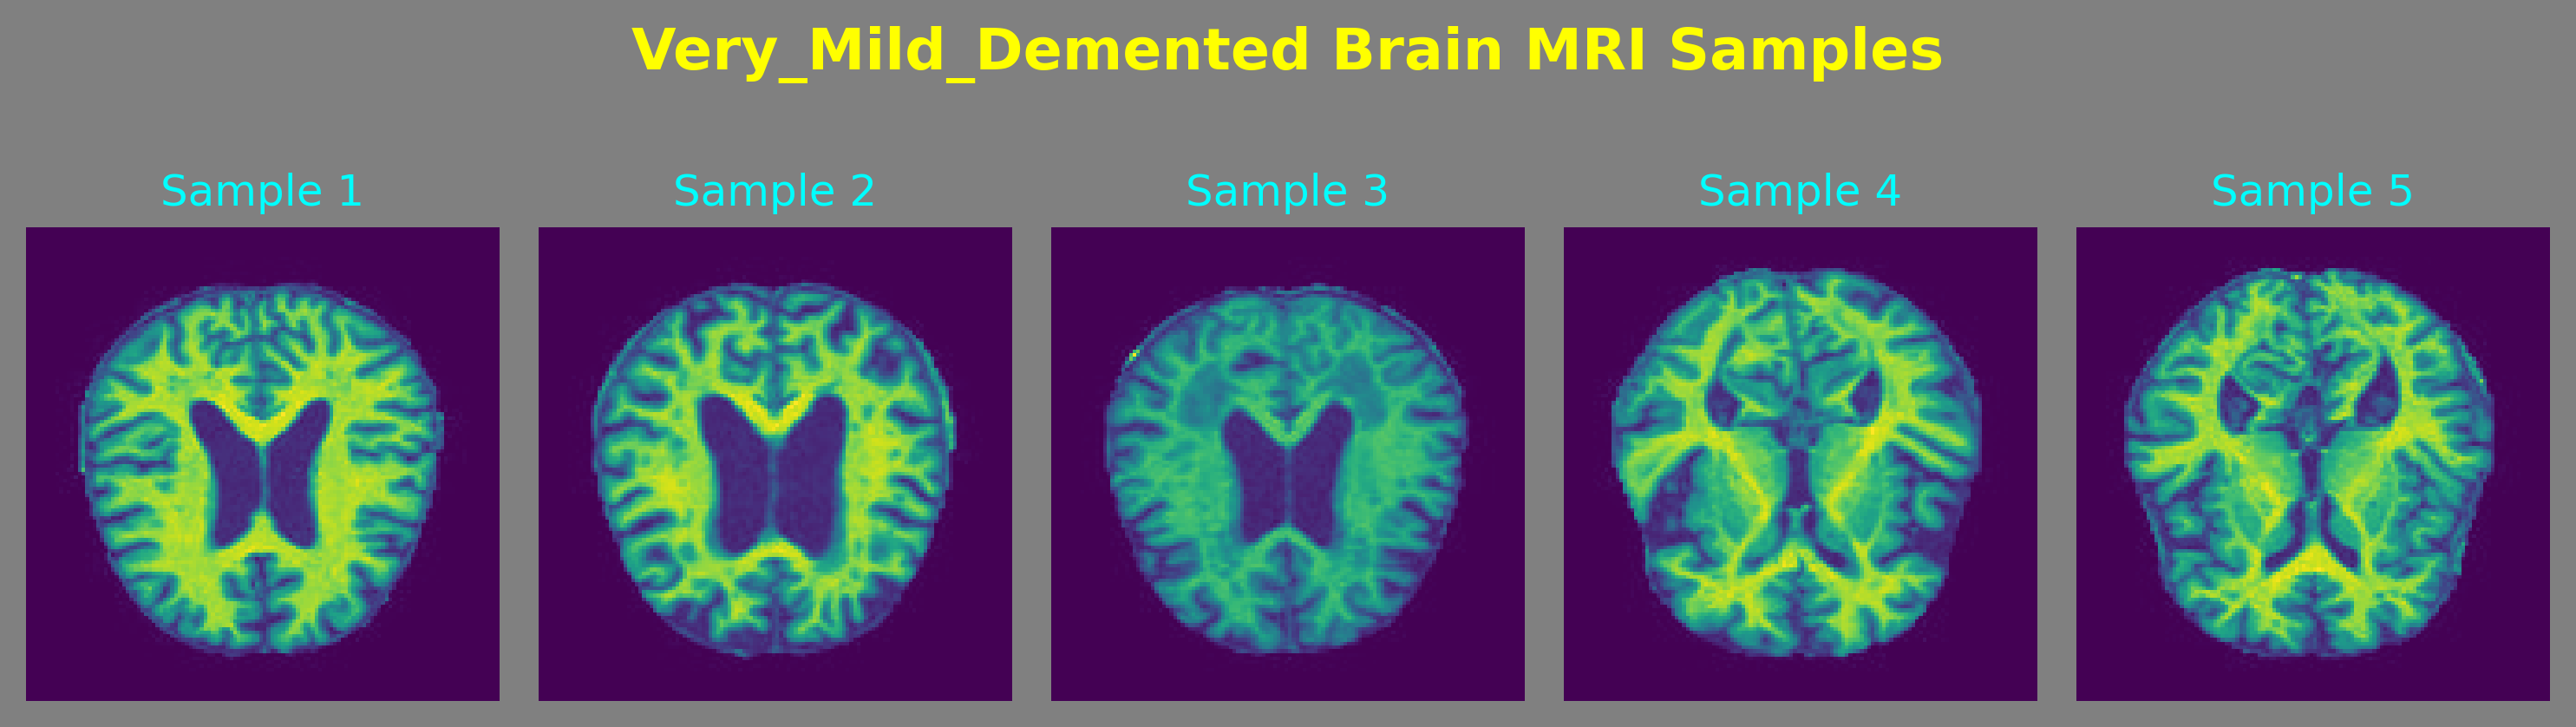

In [3]:
# Load dataset
PATH = 'Dataset'
data = tf.keras.utils.image_dataset_from_directory(PATH,
                                                batch_size=32,
                                                image_size=(128, 128),
                                                shuffle=True,
                                                seed=42)

class_names = data.class_names

# Visualize class distribution
class_dist = image_counter(PATH)
plot_class_distribution(class_dist)

# Visualize sample images
for target in class_names:
    visualize_samples(os.path.join(PATH, target))

In [5]:
# Preprocessing function
@tf.function
def preprocess_image(image):
    image = normalize_intensity(image)
    image = smooth_image(image)
    identity_matrix = np.eye(image.shape[-1])
    return image

In [8]:
# Normalize, smooth, and register images
def preprocess_dataset(data):
    def preprocess_batch(images, labels):
        images = tf.map_fn(preprocess_image, images, fn_output_signature=tf.float32)
        return images, labels
    
    return data.map(preprocess_batch)

data = preprocess_dataset(data)

# Split the data into train, validation, and test sets
def train_val_test_split(data, train_size=0.8, val_size=0.1, test_size=0.1):
    assert train_size + val_size + test_size == 1, "Train, validation, and test sizes must sum to 1"
    
    data_size = len(data)
    train_data = data.take(int(train_size * data_size))
    val_data = data.skip(int(train_size * data_size)).take(int(val_size * data_size))
    test_data = data.skip(int((train_size + val_size) * data_size))
    
    return train_data, val_data, test_data

train_data, val_data, test_data = train_val_test_split(data)

In [9]:
# Define CNN model for feature extraction
def build_feature_extractor():
    base_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten()
    ])
    
    return base_model

feature_extractor = build_feature_extractor()

# Extract features from the images using the CNN
def extract_features(data, feature_extractor):
    features = []
    labels = []

    for images, label_batch in data:
        feature_batch = feature_extractor.predict(images)
        features.extend(feature_batch)
        labels.extend(label_batch.numpy())
    
    return np.array(features), np.array(labels)

X_train, y_train = extract_features(train_data, feature_extractor)
X_val, y_val = extract_features(val_data, feature_extractor)
X_test, y_test = extract_features(test_data, feature_extractor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms

In [10]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Compute class weights
class_weights = compute_class_weights(data)

In [11]:
# Train the SVM model with class weights
svm_model = SVC(kernel='linear', probability=True, class_weight=class_weights)
svm_model.fit(X_train, y_train)

# Evaluate the SVM model
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=class_names))

                    precision    recall  f1-score   support

     Mild_Demented       1.00      0.98      0.99        82
 Moderate_Demented       1.00      1.00      1.00         7
      Non_Demented       0.99      1.00      1.00       321
Very_Mild_Demented       0.99      1.00      0.99       230

          accuracy                           0.99       640
         macro avg       1.00      0.99      0.99       640
      weighted avg       0.99      0.99      0.99       640



In [12]:
import joblib

joblib.dump(svm_model, 'Hybride_Model_last.pkl')

['Hybride_Model_last.pkl']

In [13]:
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Perform cross-validation
cv_results = cross_validate(svm_model, X_train, y_train, cv=5, 
                            scoring=['accuracy', 'f1_weighted'], 
                            return_train_score=False)

# Print cross-validation results
print("Cross-Validation Results:")
print(f"Mean Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Mean F1 Score (Weighted): {cv_results['test_f1_weighted'].mean():.4f}")

# Train the SVM model on the entire training set
svm_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = svm_model.predict(X_test)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred, target_names=class_names))

Cross-Validation Results:
Mean Accuracy: 0.9805
Mean F1 Score (Weighted): 0.9804

Classification Report on Test Set:
                    precision    recall  f1-score   support

     Mild_Demented       1.00      0.98      0.99        82
 Moderate_Demented       1.00      1.00      1.00         7
      Non_Demented       0.99      1.00      1.00       321
Very_Mild_Demented       0.99      1.00      0.99       230

          accuracy                           0.99       640
         macro avg       1.00      0.99      0.99       640
      weighted avg       0.99      0.99      0.99       640



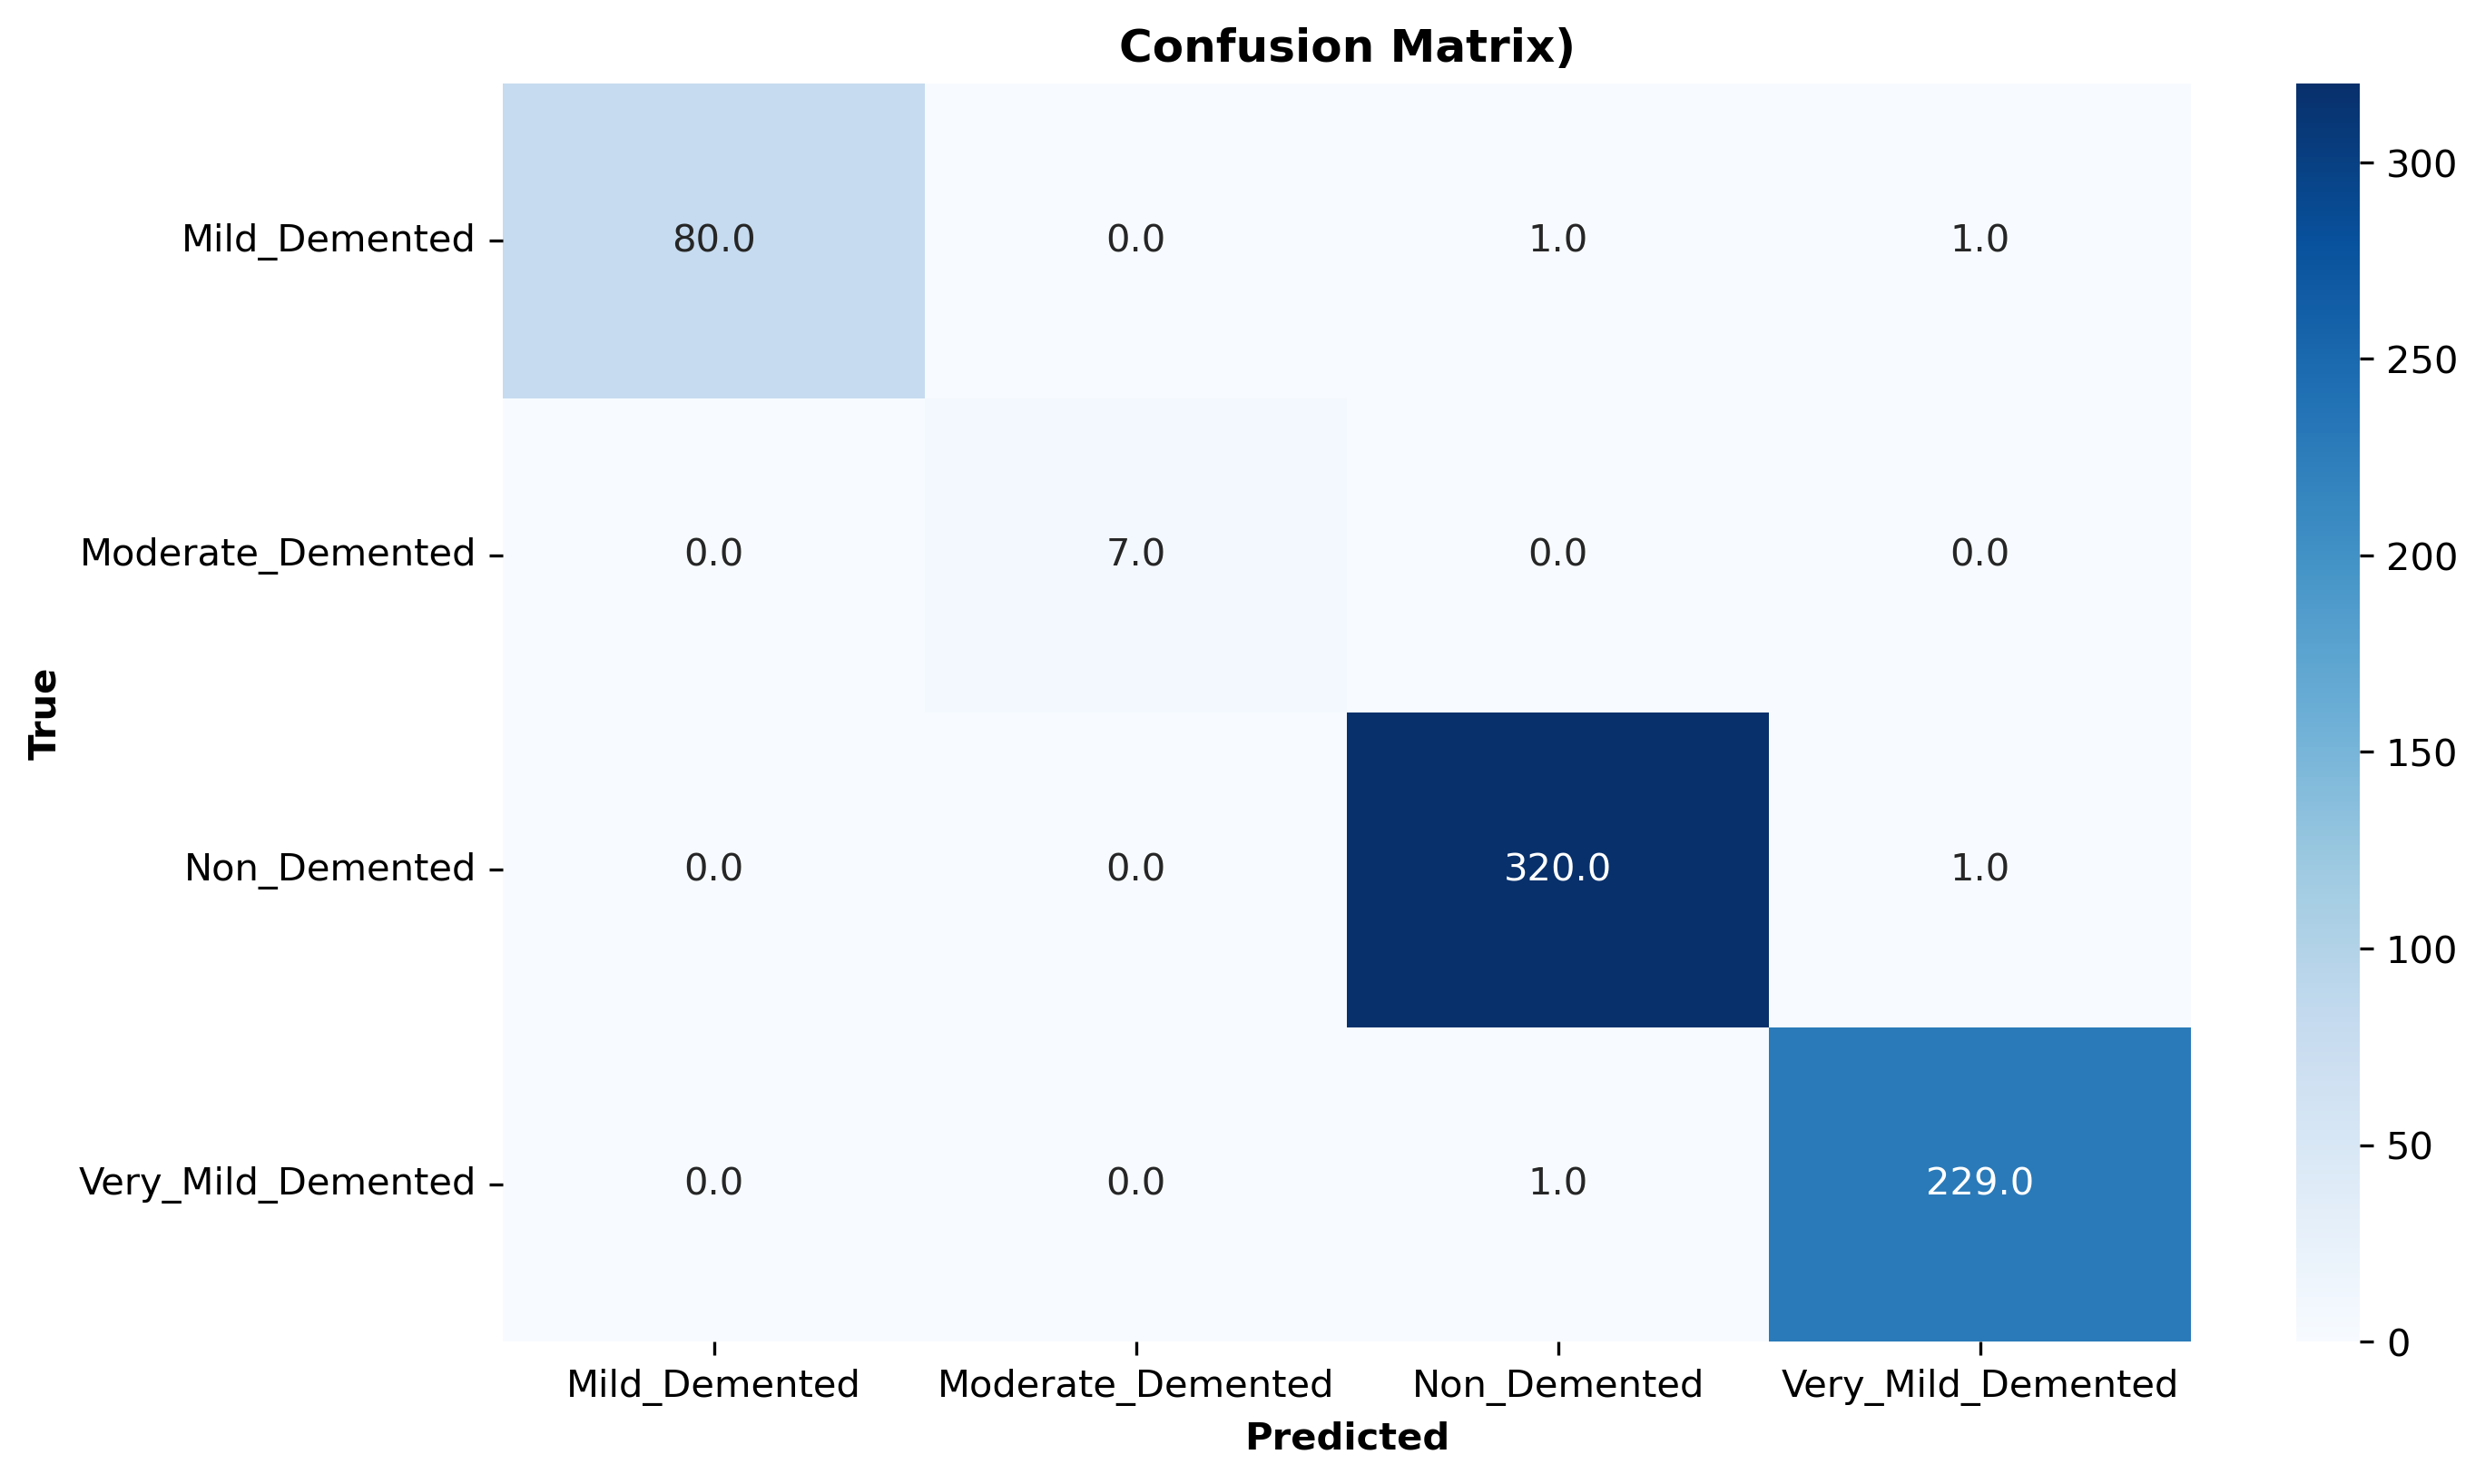

In [27]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt=".1f")
plt.title(f"Confusion Matrix)", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")
plt.show()

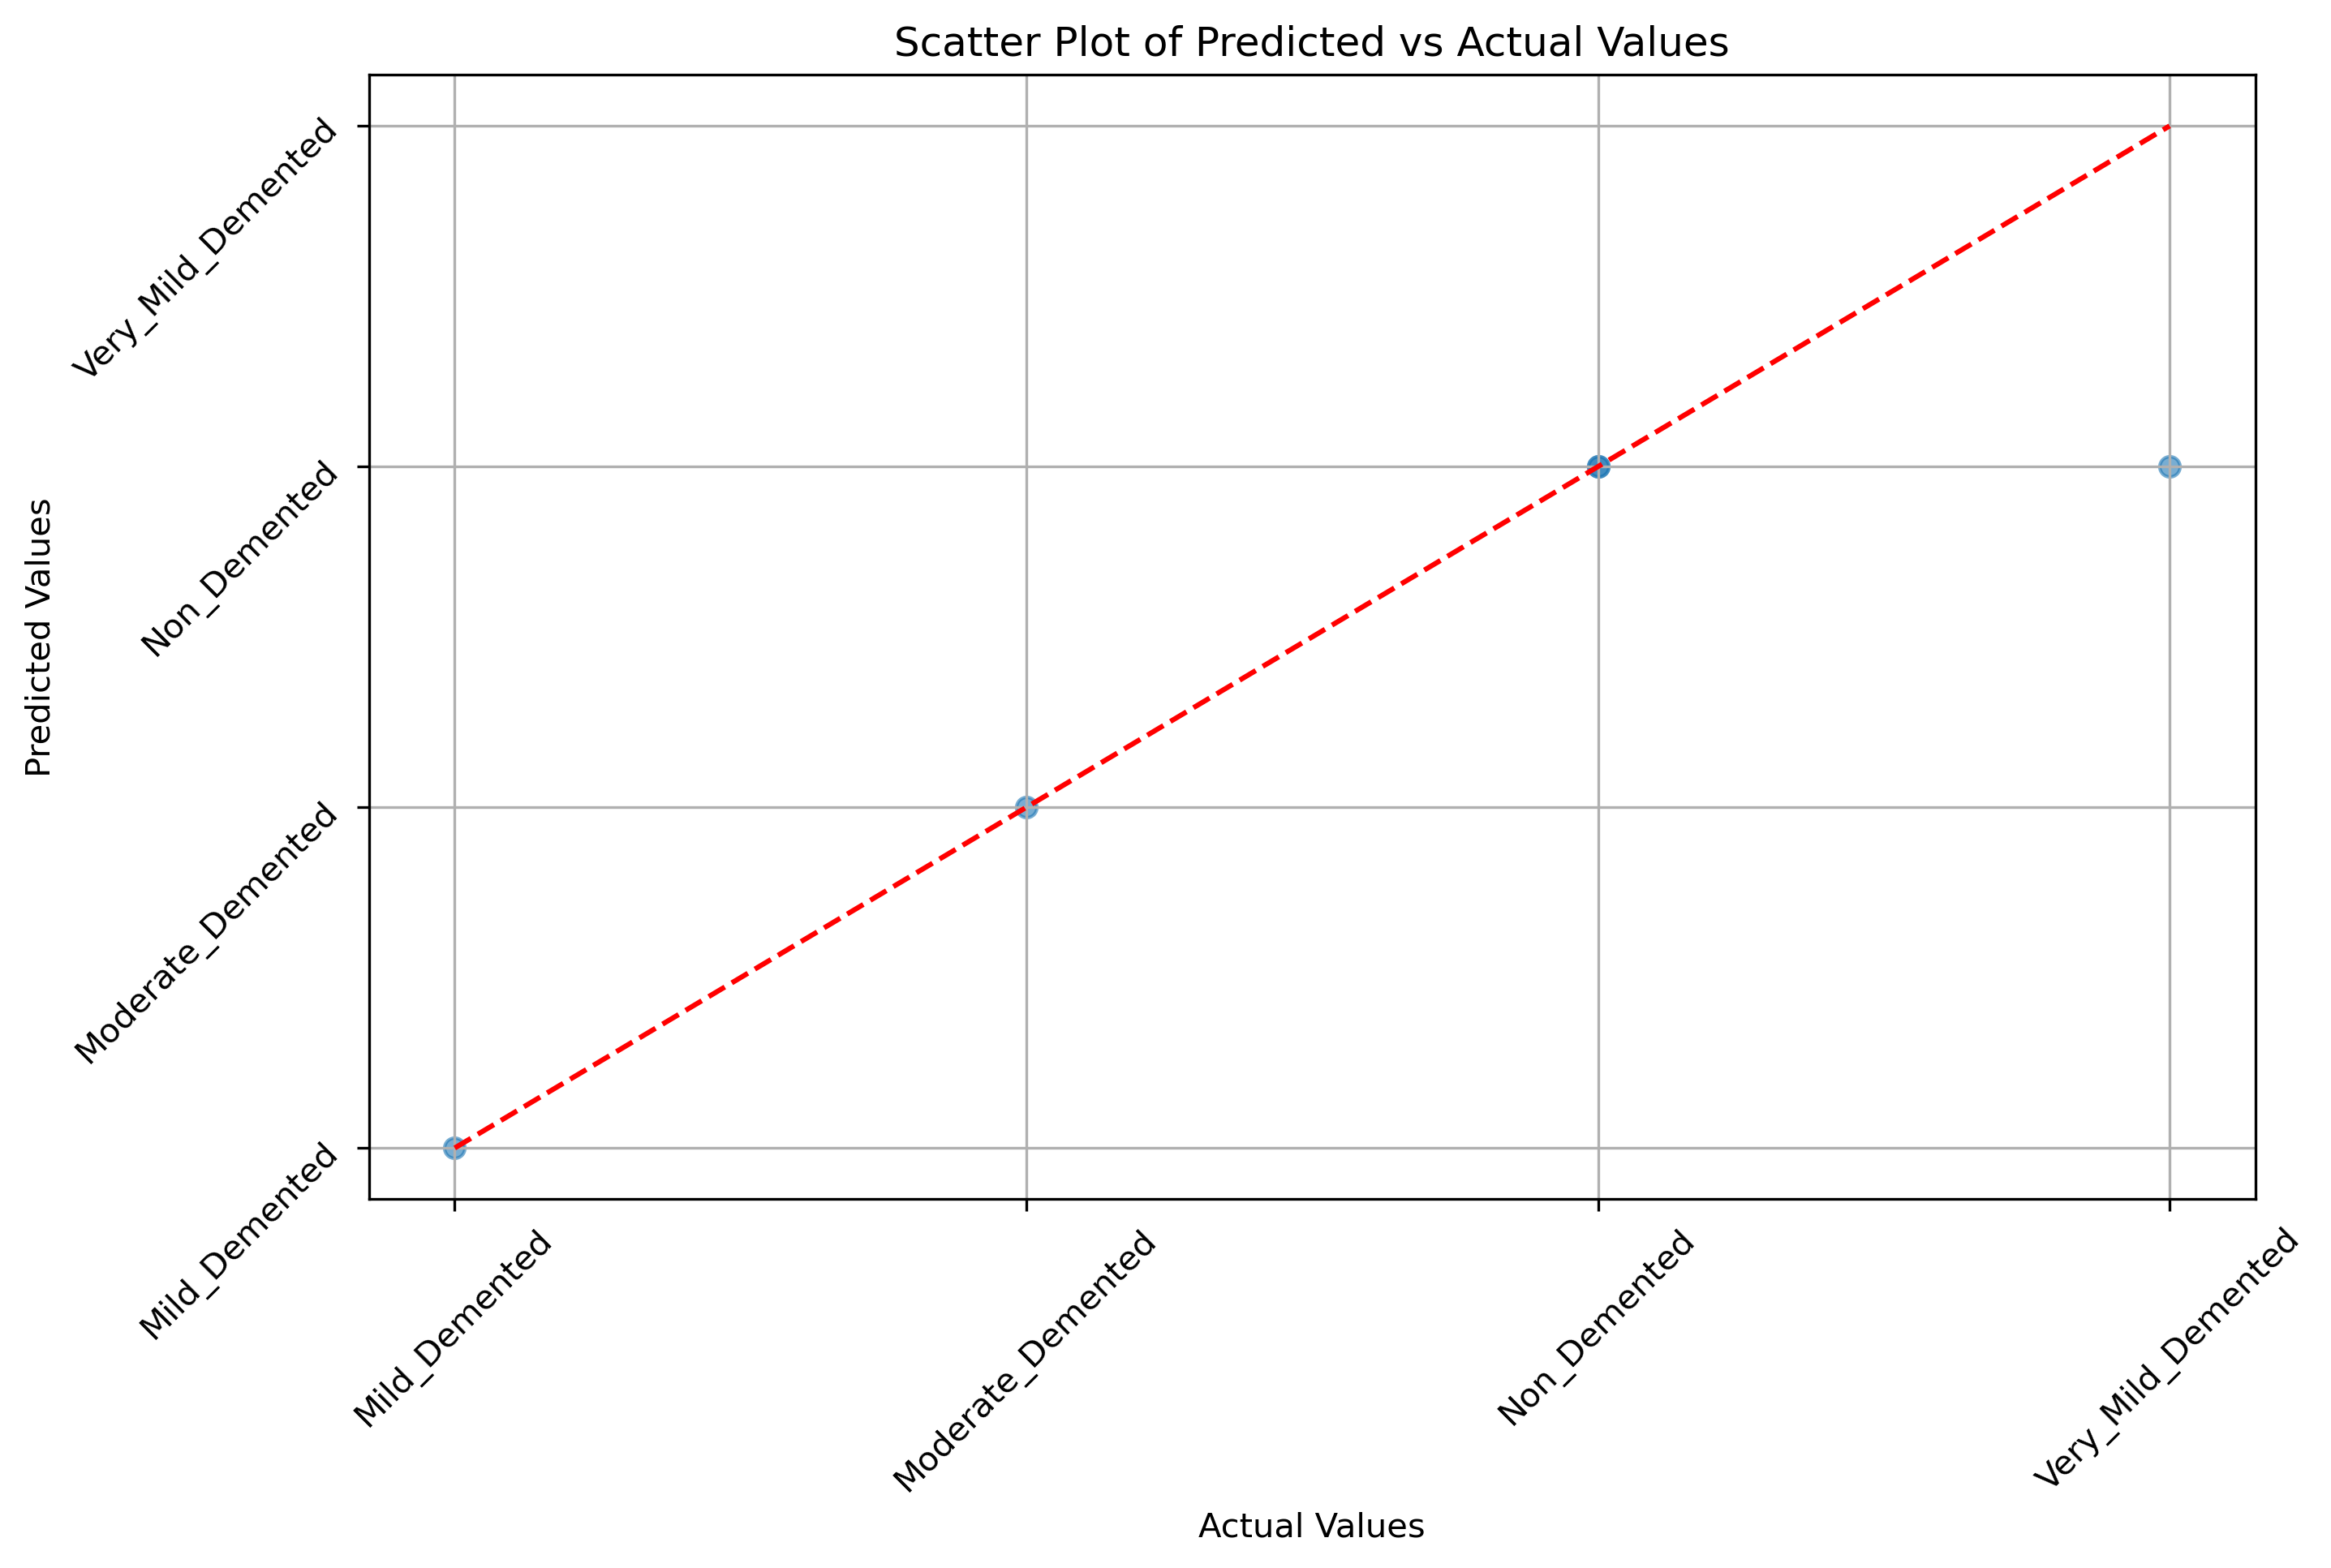

In [30]:
def plot_predicted_vs_actual(y_test, y_pred, class_names):
    # Convert labels to numerical indices
    y_test_indices = [class_names.index(label) for label in y_test]
    y_pred_indices = [class_names.index(label) for label in y_pred]
    
    plt.figure(figsize=(10, 6))
    
    # Scatter plot
    plt.scatter(y_test_indices, y_pred_indices, alpha=0.6)
    
    # Adding a line for perfect predictions
    plt.plot([min(y_test_indices), max(y_test_indices)], [min(y_test_indices), max(y_test_indices)], color='red', linestyle='--')
    
    # Labeling
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Scatter Plot of Predicted vs Actual Values')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks(range(len(class_names)), class_names, rotation=45)
    
    plt.grid(True)
    plt.show()

class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
y_test = ['Mild_Demented', 'Non_Demented', 'Very_Mild_Demented', 'Moderate_Demented', 'Non_Demented']
y_pred = ['Mild_Demented', 'Non_Demented', 'Non_Demented', 'Moderate_Demented', 'Non_Demented']
plot_predicted_vs_actual(y_test, y_pred, class_names)

In [31]:
print("Size of y_test:", len(y_test))
print("Size of y_pred:", len(y_pred))

Size of y_test: 5
Size of y_pred: 5
